## Quick intro to pytorch , digit image classification:

**Author:** `Anguelos nicolaou anguelos.nikolaou@fau.de`

### Installing Requirements:
```bash
pip install --user ipywidgets torchvision tqdm matplotlib
```

### Loading required packages

In [2]:
from __future__ import print_function
%matplotlib inline
import time
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from matplotlib import pyplot as plt
import tqdm
try:
    from tqdm import tqdm as iter_progress
except:
    iter_progress=lambda x:x
iter_progress=lambda x:x

### Have we got GPU?

In [3]:
if torch.cuda.is_available():
    print("GPU works")
    device = 'cuda'
else:
    print("CPU will have to do")
    device = 'cpu'

CPU will have to do


Processing...
Done!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


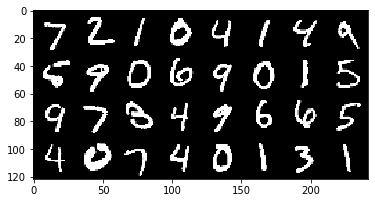

In [4]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2096, shuffle=True, num_workers=5)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2096, shuffle=False, num_workers=5)

images, labels = next(iter(testloader))
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()
plt.imshow(img.transpose(1,2,0))

### Define a simple CNN

In [5]:
class Lenet5(torch.nn.Module):
    def __init__(self):
        super(Lenet5, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 6, (5,5))
        self.conv2 = torch.nn.Conv2d(6, 10, (5,5))
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.fc1 = torch.nn.Linear(160, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc_class = torch.nn.Linear(84, 10)

    def forward(self, X):
        layer1_activations=torch.tanh(self.conv1(X))
        layer2_activations=self.pool(layer1_activations)
        layer3_activations=torch.tanh(self.conv2(layer2_activations))
        layer4_activations=self.pool(layer3_activations)
        layer4_activations=layer4_activations.view([layer4_activations.size()[0],160])
        layer5_activations=torch.tanh(self.fc1(layer4_activations))
        layer6_activations=torch.tanh(self.fc2(layer5_activations))
        output_logits = self.fc_class(layer6_activations)
        return output_logits

    def save(self, filename):
        torch.save(self.state_dict(), filename)
    
    def load(self, filename):
        self.load_state_dict(torch.load(filename))
        

### Define iterating over a single epoch
(For train and test)

In [6]:
def run_epoch(net,dataloader,criterion,device,optimizer=None):
    net.train()
    accumulated_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(iter_progress(dataloader)):
        inputs, targets = inputs.to(device), targets.to(device)
        if optimizer:
            optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        if optimizer:
            loss.backward()
            optimizer.step()
        accumulated_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct,total,accumulated_loss

### Train on CPU

Epoch: 0 Train Error: 72.45% Validation Error: 40.49% Loss: 65.28052496910095
Epoch: 1 Train Error: 34.45% Validation Error: 30.98% Loss: 53.829861998558044
Epoch: 2 Train Error: 26.85% Validation Error: 19.44% Loss: 30.917183339595795
Epoch: 3 Train Error: 16.79% Validation Error: 13.47% Loss: 19.282427728176117
Epoch: 4 Train Error: 13.02% Validation Error: 11.14% Loss: 14.508726835250854


Text(0.5, 1.0, 'Lenet5 error rates for 5 epochs on CPU 26.367 sec.')

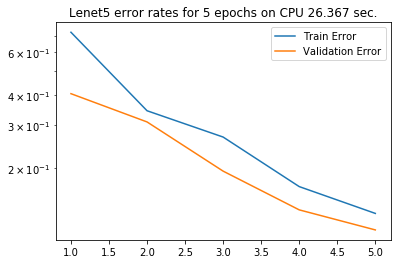

In [7]:
net=Lenet5()
net.cpu()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []
t=time.time()
for epoch in range(5):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, 'cpu', optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
        epoch,100*train_err,100*test_err,train_loss)))

plt.semilogy([1,2,3,4,5],train_performance)
plt.semilogy([1,2,3,4,5],validation_performance)
plt.legend(["Train Error","Validation Error",])
plt.title("Lenet5 error rates for 5 epochs on CPU {:0.3f} sec.".format((time.time()-t)))

#### Save the trained model:

In [9]:
torch.save(net.state_dict(), "cpu_mnist.pt")

#### Resume the model:

What is the diference between trained and untrained network?

In [10]:
net=Lenet5()
net.cpu()
test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
test_err=1-float(test_correct)/test_total
print(("Initial test error {:0.2f}%".format(100*test_err)))
net.load("cpu_mnist.pt")
test_correct,test_total,test_error=run_epoch(net, testloader, criterion, 'cpu', None)
test_err=1-float(test_correct)/test_total
print(("Resumed test error {:0.2f}%".format(100*test_err)))


Initial test error 89.76%
Resumed test error 11.14%


#### Train on GPU (at least try):

In [11]:
net=Lenet5()
#net.load("pretrained/lenet5_mnist.pt")
if device=='cuda':
    net=net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []
t=time.time()
for epoch in range(50):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    if epoch % 10 ==0:
        print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
            epoch,100*train_err,100*test_err,train_loss)))


Epoch: 0 Train Error: 80.14% Validation Error: 53.89% Loss: 65.71740412712097
Epoch: 10 Train Error: 6.92% Validation Error: 6.24% Loss: 7.3188802897930145


KeyboardInterrupt: 

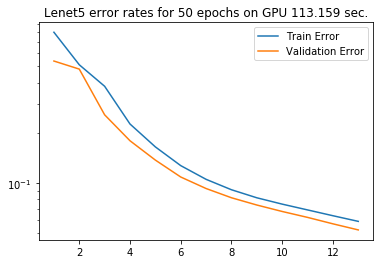

In [13]:
plt.clf()
plt.semilogy(np.arange(1,len(train_performance)+1),train_performance)
plt.semilogy(np.arange(1,len(validation_performance)+1),validation_performance)
plt.legend(["Train Error","Validation Error",])
plt.title("Lenet5 error rates for 50 epochs on GPU {:0.3f} sec.".format((time.time()-t)))
mnist_train_performance=train_performance
mnist_validation_performance=validation_performance

### How about a more difficult dataset?

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])

transform_test = transform_train

trainset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=2096, shuffle=True, num_workers=5)

testset = torchvision.datasets.FashionMNIST(root='./fashion_data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=2096, shuffle=False, num_workers=5)

images, labels = next(iter(testloader))
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy()*.3+.13
plt.imshow(img.transpose(1,2,0))
plt.title("Fashion MNIST samples")

### Train on the same model for a harder problem

In [ ]:
net=Lenet5()
#net.load("./pretrained/lenet5_fashion.pt")
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(50):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    if epoch % 10 == 0:
        print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
            epoch,100*train_err,100*test_err,train_loss)))

plt.clf()
plt.semilogy(np.arange(1,51),train_performance)
plt.semilogy(np.arange(1,51),validation_performance)
plt.semilogy(np.arange(1,51),mnist_train_performance)
plt.semilogy(np.arange(1,51),mnist_validation_performance)
plt.legend(['Fashion train error','Fashion test error','MNIST train error','MNIST test error'])
plt.title("Lenet5 error rates for 50 epochs on GPU {:0.3f} sec.".format((time.time()-t)))
mnist_train_performance=train_performance
mnist_validation_performance=validation_performance

### Define a Larger Network

In [ ]:
class ColorCNN(torch.nn.Module):
    def __init__(self,filename="",input_size=(32,32,3)):
        super(ColorCNN, self).__init__()
        self.input_size = input_size
        self.conv1 = torch.nn.Conv2d(3, 16, (3, 3))
        self.conv2 = torch.nn.Conv2d(16, 16, (3, 3))
        
        self.conv3 = torch.nn.Conv2d(16,32, (3, 3))
        self.conv4 = torch.nn.Conv2d(32, 32, (3, 3))
        
        activation_width = lambda x: (((x-4)/2)-4)/2
        activation_height = lambda x: (((x-4)/2)-4)/2
        
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.dropout2d = torch.nn.Dropout2d(p=0.1)
        self.dropout_fc = torch.nn.Dropout(p=0.1)
        
        self.last_conv_size=int(activation_width(input_size[0])*activation_height(input_size[1])*int(self.conv4.bias.shape[0]))
        
        self.fc1 = torch.nn.Linear(self.last_conv_size, 256)
        self.fc2 = torch.nn.Linear(256, 128)
        self.fc_class = torch.nn.Linear(128, 10)
        
                
    def forward(self,X):
        layer1_activations=self.dropout2d( F.relu(self.conv1(X)))
        layer2_activations=self.dropout2d( F.relu(self.conv2(layer1_activations)))
        layer3_activations=self.pool(layer2_activations)

        layer4_activations=self.dropout2d( F.relu(self.conv3(layer3_activations)))
        layer5_activations=self.dropout2d( F.relu(self.conv4(layer4_activations)))
        layer6_activations=self.pool(layer5_activations)

        layer7_activations=layer6_activations.view([layer6_activations.size()[0], self.last_conv_size])
        layer7_activations=self.dropout_fc(F.relu(self.fc1(layer7_activations)))
        layer8_activations=self.dropout_fc(F.relu(self.fc2(layer7_activations)))
        output_logits=self.fc_class(layer8_activations)
        
        return output_logits


### Load a harder dataset

In [ ]:
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

images, labels = next(iter(testloader))
img=torchvision.utils.make_grid(images[:32,:,:,:]).numpy() / 2 + 0.5
plt.imshow(img.transpose(1,2,0))

### Train the larger network on the hardest dataset

In [ ]:
net=ColorCNN()
#net.load("./pretrained.old/color_cnn.pt")
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

for epoch in range(200):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_error=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    train_performance.append(train_err)
    validation_performance.append(test_err)
    if epoch % 10 == 0:
        print(("Epoch: {} Train Error: {:0.2f}% Validation Error: {:0.2f}% Loss: {}".format(
            epoch,100*train_err,100*test_err,train_loss)))

plt.clf()
plt.semilogy(np.arange(1,201),train_performance)
plt.semilogy(np.arange(1,201),validation_performance)
plt.legend(['Cifar10 train error','Cifar10 test error'])
plt.title("Lenet5 error rates for 50 epochs on GPU {:0.3f} sec.".format((time.time()-t)))
plt.plot(train_performance)
plt.plot(test_performance)

In [ ]:
net=ColorCNN()
net.load_state_dict(torch.load("color_cnn.pt"))

### Using tensofows ploting in pytorch

#### Install tensorboardX and tensorflow
```bash
pip install --user tensorboardX tensorflow
```

#### Run tensorboard 
```bash
tensorboard --logdir runs/*/
```

#### Open your browser

http://127.0.0.1:6006

In [ ]:
import tensorboardX
net=ColorCNN()
if device=='cuda':
    net.cuda()

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=0.9, weight_decay=5e-4)

train_performance = []
validation_performance = []

writer = tensorboardX.SummaryWriter()

for epoch in range(40):
    train_correct,train_total,train_loss=run_epoch(net, trainloader, criterion, device, optimizer)
    train_err=1-float(train_correct)/train_total
    test_correct,test_total,test_loss=run_epoch(net, testloader, criterion, device, None)
    test_err=1-float(test_correct)/test_total
    
    writer.add_scalar('error/train',train_err, epoch)
    writer.add_scalar('error/test', test_err, epoch)
    
    writer.add_scalar('loss/train', train_loss, epoch)
    writer.add_scalar('loss/test', test_loss, epoch)
    filter_image=(torchvision.utils.make_grid(net.conv1.weight).data.cpu()).numpy()#.transpose(1,2,0)
    writer.add_image('filters/conv1',filter_image , epoch)
    writer.add_text('text',"Epoch: {} Train Error: {} Validation Error: {} Loss: {}".format(
        epoch,train_err,test_err,train_loss),epoch)
